In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))


#from src.main_project.NeuralNetwork import NeuralNetwork as nn
from NeuralNetwork import NeuralNetwork as nn
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf 
import matplotlib.pyplot  as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


In [2]:
# ======================#
# 1. Data Loading       #
# ======================#
def load_data():
    """Loading  MNIST dataset"""
    print("Loading MNIST dataset...")
    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()


Loading MNIST dataset...


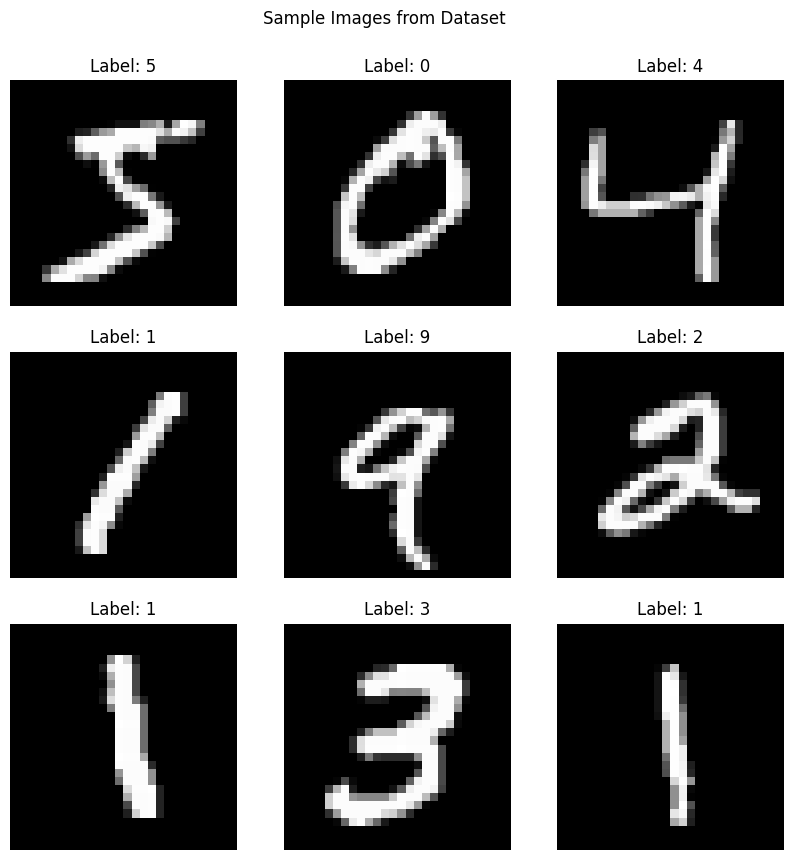

In [3]:
# ======================#
# 2. Visualize sample   #
# ======================#
def Visualize_sample(x,y,sample_Visualize_size=9):
    plt.figure(figsize=(10, 10))
    for i in range(sample_Visualize_size):
        plt.subplot(3, 3, i+1)
        plt.imshow(x[i], cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle('Sample Images from Dataset', y=0.95)
    plt.show() 
Visualize_sample(x_train, y_train)

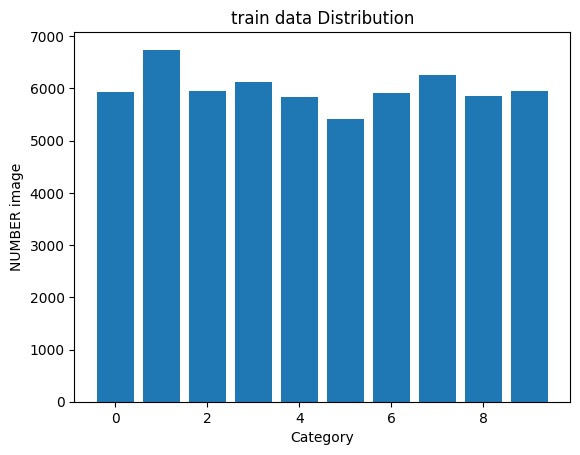

In [4]:

# ===================================#
# 3. train data Distribution         #
# ===================================#
def train_data_Distribution( y_train):
    unique,counte=np.unique(y_train, return_counts=True)
    plt.bar(unique, counte)
    plt.xlabel('Category')
    plt.ylabel('NUMBER image')
    plt.title('train data Distribution')
    plt.show()
    
train_data_Distribution( y_train)

In [5]:

# ===================================#
# 4. statistic calcul                #
# ===================================#
def valou_statistic(x_train):
    print("\n pixl statstic")
    print(f"mean {x_train.mean():.3f}")
    print(f"max {x_train.max():.3f}")
    print(f"min {x_train.min():.3f}")
    print(f"std {x_train.std():.3f}")
valou_statistic(x_train)


 pixl statstic
mean 33.318
max 255.000
min 0.000
std 78.567


In [6]:
# ======================#
# 5. Data Preprocessing #
# ======================#
def preporocess_trining_data(x_test,x_train):
    # normlayze data [0,255],[0,1]
    x_test_nom=x_test.astype('float32')/255
    x_train_nom=x_train.astype('float32')/255
    #flatten
    x_test_fatten=x_test_nom.reshape(x_test_nom.shape[0], -1)
    x_train_fatten=x_train_nom.reshape(x_train_nom.shape[0], -1)

    
    scaler = StandardScaler()
    
    
    x_train_preprocess=scaler.fit_transform(x_train_fatten)
    x_test_preprocess =scaler.transform(x_test_fatten)
    return x_train_preprocess,x_test_preprocess

x_train_preprocess,x_test_preprocess=preporocess_trining_data(x_test,x_train)
print(f"pros {x_train_preprocess[0]}")

    

pros [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.41807834e-03 -5.75481961e-03 -4.08251677e-03 -4.08251677e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.08251677e-03 -4.70968848e-03 -8.79934616e-03 -1.15905590e-02
 -1.47589808e-02 -1.92848537e-02 -2.46717986e-02 -2.90710274e-02
 -3.05926576e-02 -3.11640128e-02 -3.19628716e-02 -3.02025359e-02
 -3.13102156e-02 -2.83833947e-02 -2.31191907e-02 -1.91666279e-02
 -1.67723019e-02 -1.09963603e-02 -8.32486060e-03 -4.38069366e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.08251677e-03 -5.39534586e-03
 -8.52241181e-03 -1.

In [7]:
# ===============================#
# 6. Feature Extraction with PCA #
# ===============================#
def extract_features(x_train, x_test, variance=0.95):
    """Perform dimensionality reduction using PCA"""
    print("\n=== Feature Extraction with PCA ===")
    
    pca = PCA(n_components=variance, random_state=42)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    
    # Save the PCA transformer
    joblib.dump(pca, 'model_nn/pca_transformer.pkl')
    print("PCA transformer saved to 'pca_transformer.pkl'")

    print(f"Original number of features: {x_train.shape[1]}")
    print(f"Reduced number of features: {x_train_pca.shape[1]}")
    print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
    return x_train_pca,x_test_pca

x_train_pca,x_test_pca=extract_features(x_train_preprocess,x_test_preprocess)


=== Feature Extraction with PCA ===
PCA transformer saved to 'pca_transformer.pkl'
Original number of features: 784
Reduced number of features: 331
Explained variance ratio: 0.95


In [8]:
# ======================#
# 7. nn Model Training  #
# ======================#
def train_model(x_train, y_train,sample_size=1000):
    """Train SVM model with cross-validation"""
    print("\n=== nn Model Training ===")
    input_size=x_train.shape[1]#number colm 
    output_size=len(np.unique(y_train, return_counts=False))
    print(output_size)
    hidden_size=128
    model_nn=nn.NeuralNetwork(input_size,hidden_size,output_size=10,activation_name="sigmoid")
    #print(y_train[:sample_size].shape)
    encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = encoder.fit_transform(y_train[:sample_size].reshape(-1, 1))
    model_nn.train(x_train[:sample_size],y_train_encoded ,epoch=10000,learn_rate=0.01)

    return model_nn
    

model_nn=train_model(x_train_pca,y_train,sample_size=1000)


=== nn Model Training ===
10
Epoch 0, Loss: 0.4978375981141152
Epoch 1000, Loss: 0.01178927179472755
Epoch 2000, Loss: 0.005756959533602327
Epoch 3000, Loss: 0.005151142907425956
Epoch 4000, Loss: 0.004544372151899635
Epoch 5000, Loss: 0.004224975106438343
Epoch 6000, Loss: 0.0040218185163151225
Epoch 7000, Loss: 0.004016533899232642
Epoch 8000, Loss: 0.003938358563828422
Epoch 9000, Loss: 0.003813090012909935


In [9]:
# =========================#
# 8. Model Saving Function #
# =========================#
def save_model(model, filename='model_nn/mnist_nn_model.pkl'):
    """Saves the trained model to disk with robust error handling"""
    try:
        # Extract directory path (if any)
        dir_path = os.path.dirname(filename)
        
        # Create directory only if path exists
        if dir_path and not os.path.exists(dir_path):
            os.makedirs(dir_path)
            
        # Save model
        joblib.dump(model, filename)
        print(f"❤️❤️❤️❤️ Model successfully saved to {os.path.abspath(filename)}")
        return True
        
    except Exception as e:
        print(f" 😢😢😢 Failed to save model to {filename}: {str(e)}")
        return False
save_model(model_nn)#if you fil path add it here

❤️❤️❤️❤️ Model successfully saved to c:\Users\yasse\OneDrive\Desktop\jupyter\ml NN\reptository\examples\model_nn\mnist_nn_model.pkl


True

In [10]:
# =========================#
# 9. Model load  Function #
# =========================#
def load_model( filename='model_nn/mnist_nn_model.pkl'):
    try:

        loaded_model = joblib.load(filename)
        print(f"Model 👌👌👌 '{filename}' loaded successfully.")
        return loaded_model



    except FileNotFoundError:
        print(f" 😢😢😢Error: Model file '{filename}' not found.")
    except Exception as e:
        print(f"😅😅😅 An error occurred while loading the model: {e}")
model_nn=load_model()
    

Model 👌👌👌 'model_nn/mnist_nn_model.pkl' loaded successfully.


In [11]:
# ============================#
# 10. nn Model test Evaluate   #
# ============================#
def test_model(model_nn,x_test, y_test,sample_size=1000):
    predicte_value=model_nn.predict(x_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, predicte_value)
    print(f"\n Test Accuracy: {accuracy * 100:.2f}%")

    #MSE
    mse=model_nn.MSE(y_test, predicte_value)
    print(f"\n Test mse: {mse**0.5:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, predicte_value)
    print("\n Confusion Matrix:")
    print(cm)


    # Classification Report
    print("\n Classification Report:")
    print(classification_report(y_test, predicte_value))

    # Optional: Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()




 Test Accuracy: 73.94%

 Test mse: 142.48

 Confusion Matrix:
[[ 849    1   18   14    2   35   30   18    8    5]
 [   0 1060   12    9    3    1    5    7   31    7]
 [  27   18  725   43   20   28   34   48   63   26]
 [  22    9   72  616    8  136   12   47   64   24]
 [   1   10   20    8  730   19   51   26   14  103]
 [  33   18   25   51   47  561   38   26   77   16]
 [  31    7   83    2   54   36  709   15   17    4]
 [   4   13   33   20   19   10   10  831   13   75]
 [  18   25   49   32   30   86   31   29  624   50]
 [  12    9   21   20   78   28   17  116   19  689]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       980
           1       0.91      0.93      0.92      1135
           2       0.69      0.70      0.69      1032
           3       0.76      0.61      0.68      1010
           4       0.74      0.74      0.74       982
           5       0.60      0.63      0.61       892
  

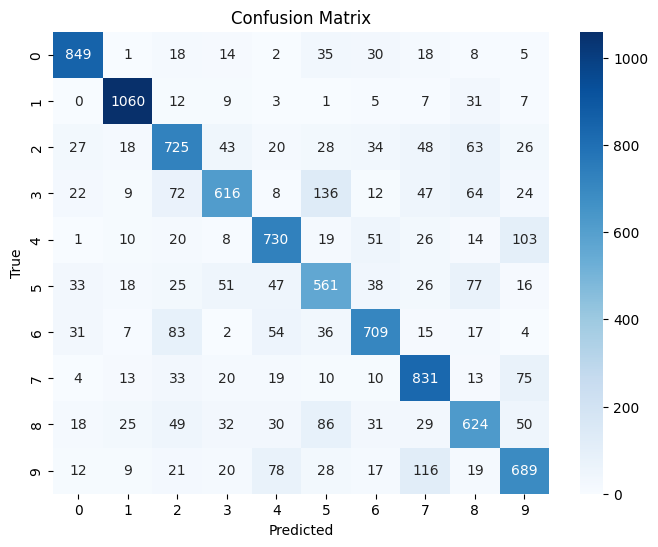

In [12]:
test_model(model_nn,x_test_pca,y_test)